In [1]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

rcParams = {'font.size': 24 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}
plt.rcParams.update(rcParams)

def Load_PAF(filepath):
    lines = open(filepath).readlines()
    header = ['Query','Qlen','QStart','QEnd','Orientation','Subject','SLen',
              'SStart','SEnd','Matches','AlignLength','MAPQ']
    op = []
    for l in lines:
        l = l.split('\t')[:12]
        op.append(dict(zip(header, l)))
    df = pd.DataFrame(op)
    df[['Qlen','QStart','QEnd','SLen','SStart',
        'SEnd','Matches','AlignLength','MAPQ']] = df[['Qlen','QStart','QEnd','SLen','SStart',
                                                      'SEnd','Matches','AlignLength','MAPQ']].astype('int')
    df['PIdent'] = df['AlignLength']/df['Qlen']*100
    df = df.loc[df.groupby(['Query'])['PIdent'].idxmax()]
    df = df[['Query','Qlen','PIdent']]
    df = df.rename(columns = {'Query':'Contig'})
    df = df.set_index('Contig')
    return df


In [2]:
fdir = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/reassembly/\
Differential_Read_Counting/'
paf = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/reassembly/contig_mapping_paf/'

files = listdir(fdir)

orphaned_reads_counts = {}

for f in files:
    sample = f.replace("_Diff_Read_Count","")
    if f.startswith("Hot"):
        print(sample)
        df_osa_read_counts = pd.read_csv(fdir+f+'/OSA.Orphaned_Read_Counts', sep = "\t", index_col = 'Contig')
        df_osb_read_counts = pd.read_csv(fdir+f+'/OSB.Orphaned_Read_Counts', sep = "\t", index_col = 'Contig')
        df_osa_paf = Load_PAF(paf+sample+'_osa_contigs_aligned_to_osa.paf')
        df_osb_paf = Load_PAF(paf+sample+'_osb_contigs_aligned_to_osb.paf')
        df_osa = df_osa_read_counts.join(df_osa_paf, how = 'left')
        df_osa = df_osa.reset_index()
        df_osb = df_osb_read_counts.join(df_osb_paf, how = 'left')
        df_osb = df_osb.reset_index()
        orphaned_reads_counts[sample] = {'OSA':df_osa, 'OSB':df_osb}

Hotspr20Samplet1
Hotspr2Sample149
HotsprSampleR4cd
HotsprSampOS1260
HotsprSampleOS50
HotsprSampleMS50
HotsprSampleOS60
HotsprSampleMSe3
Hotspr20SampleT9
HotsprSampleOS55
HotsprSamplt10cd
HotsprSampleMSe4
HotsprSampleOSM1
HotsprSampleMS65
HotsprSampleOS65
HotsprSampOS1265
HotsprSampleOSM4
HotsprSampleMS55
HotsprSampleOSM3
HotsprottomLayer
Hotspr20SampleT8
Hotspr20SampleP4
HotsprottomLayer_2
HotsprSampleMSe1
Hotspr2Sampleme2
HotsprOSTMatCore
Hotspr2Sample148
HotsprSampleMS13
HotsprSampleMSe2
Hotspr2SamplePe2
Hotspr20Samplem2
HotsprSampleMS60
Hotspr2Sampleee2
HotsprSampleOSM2


In [3]:
df_novel_contigs = pd.read_csv('/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/\
Ref_Guided_Scaffolding_Clustering_Aug_2022/BLAST_All_vs_All/Containment_Clusters_Filtered_90_75_1000.txt', 
                               sep = '\t')
print(len(df_novel_contigs))
novel_contig_dict = {}
novel_contigs = list(set(df_novel_contigs['Contig'].tolist()))
for n in novel_contigs:
    splits = n.split('_')
    if len(splits) == 4:
        sample = splits[0]
        genome = splits[1].upper()
        contig = splits[2]+'_'+splits[3]
    if len(splits) == 5:
        sample = splits[0] + '_' +splits[1]
        genome = splits[2].upper()
        contig = splits[3]+'_'+splits[4]
    try:
        novel_contig_dict[sample][genome].append(contig)
    except KeyError:
        novel_contig_dict[sample] = {'OSA':[], 'OSB':[]}
        novel_contig_dict[sample][genome].append(contig)
    

4320


In [4]:
df_novel_read_counts = pd.DataFrame()
df_not_novel_read_counts = pd.DataFrame()

for k in novel_contig_dict.keys():
    print(k)
    osa = orphaned_reads_counts[k]['OSA']
    sel_novel = osa.loc[osa['Contig'].isin(novel_contig_dict[k]['OSA'])]
    sel_novel['Sample'] = k
    sel_novel['Genome'] = 'osa'
    df_novel_read_counts = df_novel_read_counts.append(sel_novel, ignore_index = True)
    
    sel = osa.loc[~osa['Contig'].isin(novel_contig_dict[k]['OSA'])]
    sel['Sample'] = k
    sel['Genome'] = 'osa'
    df_not_novel_read_counts = df_not_novel_read_counts.append(sel, ignore_index = True)
    
    osb = orphaned_reads_counts[k]['OSB']
    sel_novel = osb.loc[osb['Contig'].isin(novel_contig_dict[k]['OSB'])]
    sel_novel['Sample'] = k
    sel_novel['Genome'] = 'osb'
    df_novel_read_counts = df_novel_read_counts.append(sel_novel, ignore_index = True)
    
    sel = osb.loc[~osb['Contig'].isin(novel_contig_dict[k]['OSB'])]
    sel['Sample'] = k
    sel['Genome'] = 'osb'
    df_not_novel_read_counts = df_not_novel_read_counts.append(sel, ignore_index = True)
    
df_novel_read_counts['Or_Ratio'] = (df_novel_read_counts['Orphaned_Read_Flag(Aligned)']+
                                    df_novel_read_counts['Orphaned_Read_Flag(Non-Aligned)'])/df_novel_read_counts['Read']*100
df_not_novel_read_counts['Or_Ratio'] = (df_not_novel_read_counts['Orphaned_Read_Flag(Aligned)']+
                                        df_not_novel_read_counts['Orphaned_Read_Flag(Non-Aligned)'])/df_not_novel_read_counts['Read']*100

Hotspr20SampleT8
HotsprSampleMSe2
HotsprSampleR4cd


/Users/harihara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/harihara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/harihara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

Hotspr20Samplem2
Hotspr2SamplePe2
HotsprSampleMS65
Hotspr20SampleT9
HotsprSamplt10cd
Hotspr20SampleP4
HotsprSampleOS55
HotsprSampleOSM4
HotsprSampleMS50
HotsprSampleOSM3
HotsprSampleMS13
Hotspr2Sample149
Hotspr2Sampleme2
HotsprSampleOSM2
HotsprSampleOS60
HotsprottomLayer
HotsprSampleMSe1
HotsprSampleMSe4
HotsprSampleOS65
HotsprSampleMS55
HotsprSampleMS60
HotsprSampleOS50
HotsprSampleMSe3
Hotspr2Sampleee2
HotsprSampleOSM1
HotsprSampOS1260
HotsprSampOS1265
Hotspr2Sample148
Hotspr20Samplet1
HotsprOSTMatCore
HotsprottomLayer_2


4320 4304
1609154 262223


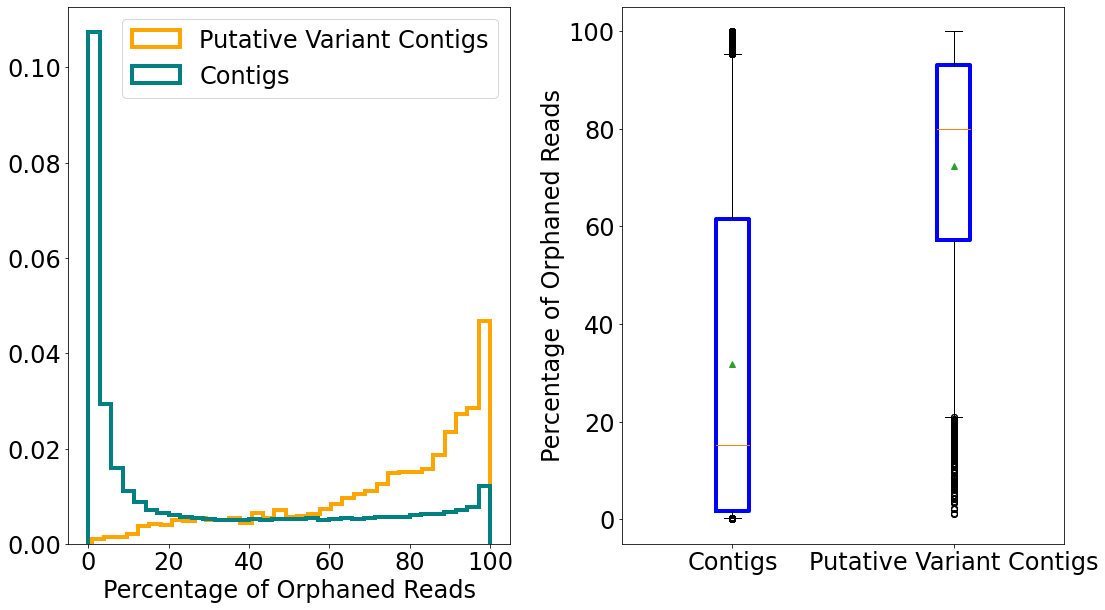

In [5]:
plt.rcParams.update(rcParams)
min_read_count = 20
df_novel_filter = df_novel_read_counts[df_novel_read_counts['Read'] > min_read_count]
df_not_novel_filter = df_not_novel_read_counts[(df_not_novel_read_counts['Read'] > min_read_count) & 
                                               (df_not_novel_read_counts['Qlen'] >= 500) &
                                               (df_not_novel_read_counts['PIdent'] >= 80)]
print(len(df_novel_read_counts), len(df_novel_filter))
print(len(df_not_novel_read_counts), len(df_not_novel_filter))

fig, ax = plt.subplots(1,2,figsize = (16,9))
ax[0].hist(df_novel_filter['Or_Ratio'], bins = 35, density = True, cumulative = False, color = 'orange', 
            histtype = 'step', label = 'Putative Variant Contigs', linewidth = 4)
ax[0].hist(df_not_novel_filter['Or_Ratio'], bins = 35, density = True, cumulative = False, color = 'teal', 
           histtype = 'step', label = 'Contigs', linewidth = 4)
ax[0].set_xlabel('Percentage of Orphaned Reads')
ax[0].legend()

boxprops = dict(linewidth=4, color='blue')
ax[1].boxplot([df_not_novel_filter['Or_Ratio'].tolist(), df_novel_filter['Or_Ratio'].tolist()], 
              whis = [5, 95], boxprops=boxprops, showmeans = True, showfliers = True)

ax[1].set_xticklabels(['Contigs', 'Putative Variant Contigs'])
ax[1].set_ylabel('Percentage of Orphaned Reads')

fig.tight_layout()

#fig.savefig('/Users/harihara/Research-Activities/Plots/Hot_Spring_Plots/Synechococcus-Paper/Orphaned_Reads.pdf')

In [13]:
mu_x1 = df_novel_filter['Or_Ratio'].mean()
mu_x2 = df_not_novel_filter['Or_Ratio'].mean()

sd_x1 = df_novel_filter['Or_Ratio'].std()/(len(df_novel_filter)**0.5)
sd_x2 = df_not_novel_filter['Or_Ratio'].std()/(len(df_not_novel_filter)**0.5)

z = (mu_x1 - mu_x2)/(sd_x1**2 + sd_x2**2)**0.5

print('Z-statistic')
if z >= 3.0:
    print('Z-value:',z)
    print('The difference in orphaned-reads between novel and non-novel contigs are highly significant')
elif z >= 2.5 and z < 3.0:
    print('Z-value:',z)
    print('The difference in orphaned-reads between novel and non-novel contigs are significant')
elif z >= 2.0 and z < 2.5:
    print('Z-value:',z)
    print('The difference in orphaned-reads between novel and non-novel contigs are marginally significant')  
elif z < 3.0:
    print('Z-value:',z)
    print('The difference in orphaned-reads between novel and non-novel contigs are insignificant')

print('\nKS-Test')
print(ks_2samp(df_novel_read_counts['Or_Ratio'], df_not_novel_read_counts['Or_Ratio']))

###The two distributions are very different 

Z-statistic
Z-value: 103.90431188881229
The difference in orphaned-reads between novel and non-novel contigs are highly significant

KS-Test
KstestResult(statistic=0.5898389631146875, pvalue=0.0)
